In [1]:
import uproot
import re
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import torch_geometric.transforms as T

from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm

In [2]:
fold   = '/lhome/ific/f/fkellere/weaver-benchmark/weaver/output_PN_Krishan_3cm_all/'
#source = '/lhome/ific/f/fkellere/Input_Dataframes/MC_dataset_Marija_10mm_SB50.h5'

In [3]:
def PN_analysis(folder, file, test):
    tree = uproot.open(folder+file)['Events']
    ## create a data-frame from all branches included in the TTree
    df = tree.arrays(tree.keys(),library='pd')
    
    if test:
        E = df['E_tot'].values
        
        '''## load source and create energy histogram
        Source      = pd.read_hdf(source,'DATASET/Voxels')
        Source      = Source[Source.binclass!=2]
        c2 = Source.dataset_id.unique()[int(3*len(Source.dataset_id.unique())/4)]
        C2 = max([i for i,x in enumerate(Source.dataset_id) if x==c2])
        source_test = Source.iloc[C2+1:]
        E           = np.array(source_test.groupby(['dataset_id'])['energy'].sum())

        # De-shuffle neural net output
        binclass = source_test.groupby('dataset_id').first().binclass.reset_index(drop=True)
        Split    = np.split(np.array(df.is_signal),np.arange(1,int(len(df)/1024)+1)*1024)

        def to_string(arr):
            return ''.join(map(chr, arr))

        def get_index(i,j):
            return np.array([m.start() for m in re.finditer(to_string(Split[i][0:j]), to_string(binclass))])

        Indices = []
        for i in tqdm(range(0,len(Split))):
            A = get_index(i,1024)
            if len(A)==1:
                Indices = np.concatenate([Indices,np.arange(A[0],A[0]+1024)])
            if len(A)==0:
                for j in reversed(range(100,1024)):
                    B = get_index(i,j)
                    if len(B)==0:
                        continue
                    else:
                        Indices = np.concatenate([Indices,np.arange(B[0],B[0]+j)])
                        C = np.array([m.start() for m in re.finditer(to_string(Split[i][j:1024]), to_string(binclass))])
                        if len(C)==1:
                            Indices = np.concatenate([Indices,np.arange(C[0],C[0]+1024-j)])
                        break

        Indices  = np.concatenate([Indices,np.setdiff1d(np.arange(0,len(binclass)),Indices)])
        U        = np.unique(list(Indices),return_index=True)[1]
        Indices  = np.array([Indices[index] for index in sorted(U)])
        df.index = Indices.astype('int')
        df       = df.sort_index()
        print(f'De-shuffling accuracy: {np.sum(binclass==df.is_signal)/len(binclass)}')'''
    
    y_test = df['is_signal'].values
    y_pred = df['score_is_signal'].values
            
    # calculate scores
    B_score = []
    S_score = []
    t = tqdm(range(0, len(y_pred)))

    for i in t:
        if y_test[i]==0:
            B_score.append(y_pred[i])
        else:
            S_score.append(y_pred[i])
            
    # create ROC curves and FOM
    fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    Seff = []
    Brej = []
    Figm = []
    thre = np.linspace(min(y_pred),max(y_pred),100)
    t    = tqdm(range(0,len(thre)))

    for i in t:
        Seff.append(len([x for x in S_score if x>=thre[i]])/len(S_score))
        Brej.append(1-len([x for x in B_score if x>=thre[i]])/len(B_score))
        Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/
                (np.sqrt(len([x for x in B_score if x>=thre[i]]))*len(S_score)))
    
    if test:
        return y_test, y_pred, fpr_gnn, tpr_gnn, threshold_gnn, Seff, Brej, Figm, thre, B_score, S_score, E
    else:
        return y_test, y_pred, fpr_gnn, tpr_gnn, threshold_gnn, Seff, Brej, Figm, thre, B_score, S_score

In [4]:
y_test, y_predict, fpr_gnn_tr, tpr_gnn_tr, threshold_gnn_tr, Seff_tr, Brej_tr, Figm_tr, thre_tr, B_score_tr, S_score_tr = PN_analysis(fold,'particlenet_predict_train.root',False)
y_test, y_predict, fpr_gnn_vl, tpr_gnn_vl, threshold_gnn_vl, Seff_vl, Brej_vl, Figm_vl, thre_vl, B_score_vl, S_score_vl = PN_analysis(fold,'particlenet_predict_valid.root',False)
y_test, y_predict, fpr_gnn_te, tpr_gnn_te, threshold_gnn_te, Seff_te, Brej_te, Figm_te, thre_te, B_score_te, S_score_te, E = PN_analysis(fold,'particlenet_predict.root',True)


  0%|          | 0/365903 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_127096/1989910288.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


  0%|          | 0/183948 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_127096/1989910288.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


  0%|          | 0/183543 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_127096/1989910288.py:76: RuntimeWarning: divide by zero encountered in double_scalars
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


In [5]:
Loss   = []
with open(f'{fold}LossFile.out') as f:
    file = f.readlines()
for line in file:
    if 'Train AvgLoss:' in line:
            loss = re.search("\d+\.\d+",line)
            loss = float(loss.group())
            Loss.append(loss)

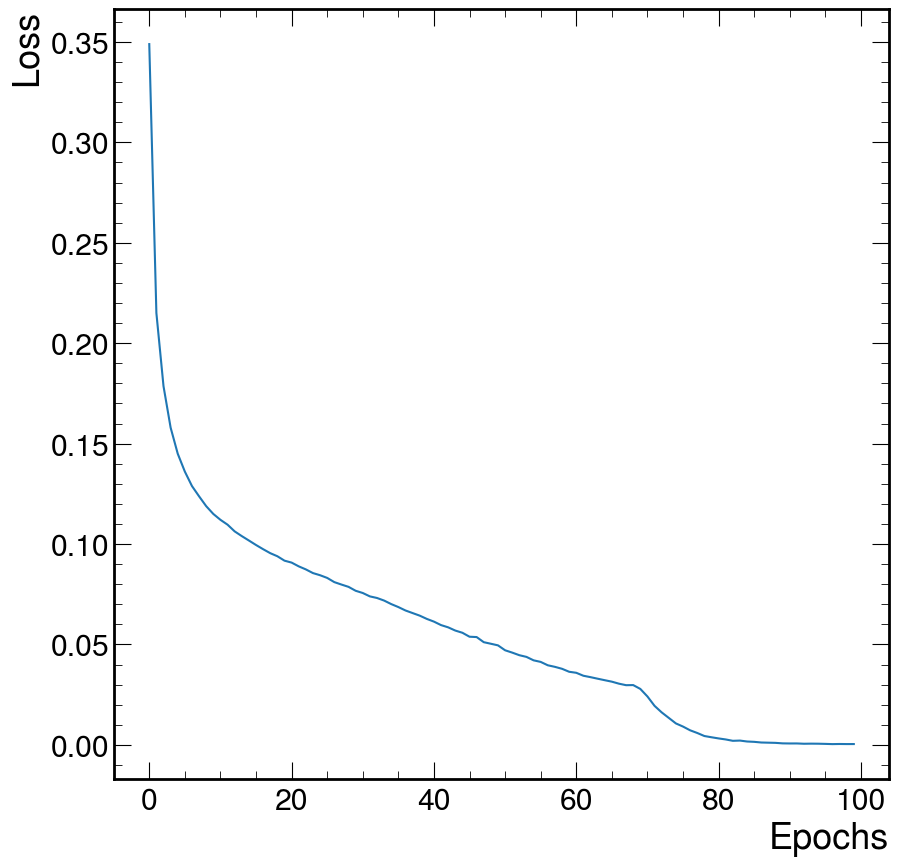

In [6]:
#plt.plot([0.26485,0.17704,0.15878,0.15081,0.14574,0.14199,0.13932,0.13701,0.13548,0.13387,0.13253,0.13134,
#         0.13030,0.12939,0.12259,0.11862,0.11614,0.11504,0.11436,0.11371])
plt.style.use(hep.style.ROOT)
plt.plot(Loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(f'{fold}/Loss.png',bbox_inches='tight')

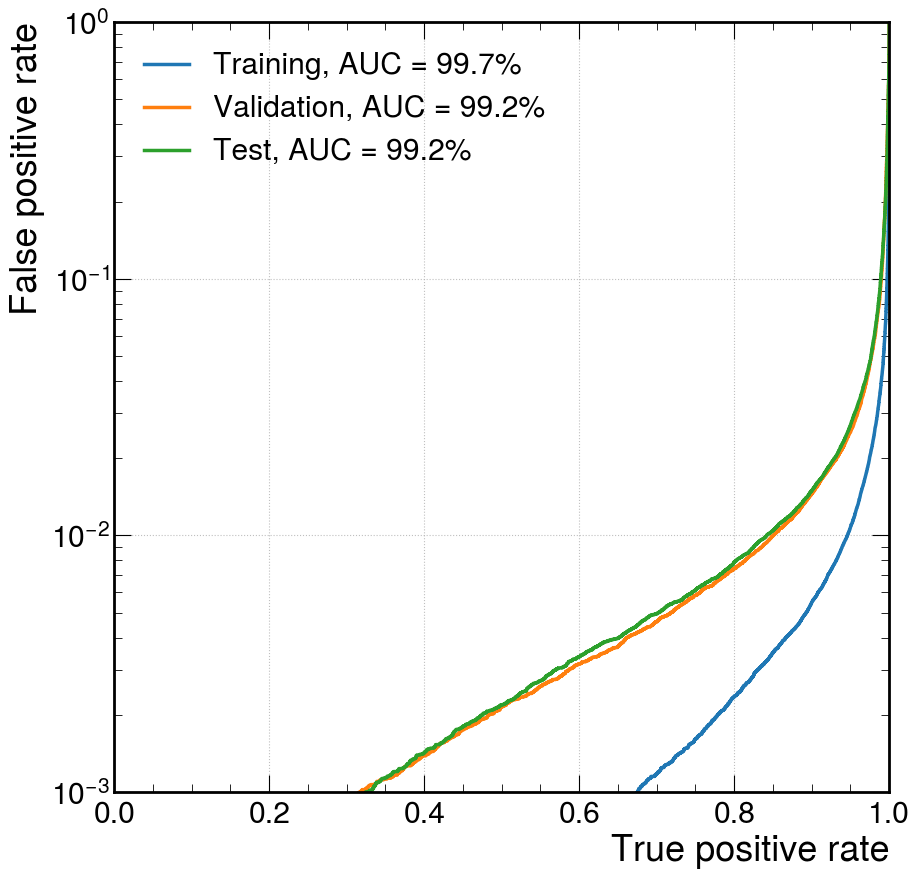

<Figure size 1000x1000 with 0 Axes>

In [7]:
plt.style.use(hep.style.ROOT)
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn_tr, fpr_gnn_tr, lw=2.5, label="Training, AUC = {:.1f}%".format(auc(fpr_gnn_tr,tpr_gnn_tr)*100))
plt.plot(tpr_gnn_vl, fpr_gnn_vl, lw=2.5, label="Validation, AUC = {:.1f}%".format(auc(fpr_gnn_vl,tpr_gnn_vl)*100))
plt.plot(tpr_gnn_te, fpr_gnn_te, lw=2.5, label="Test, AUC = {:.1f}%".format(auc(fpr_gnn_te,tpr_gnn_te)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()
plt.savefig(f'{fold}/ROC.png',bbox_inches='tight')

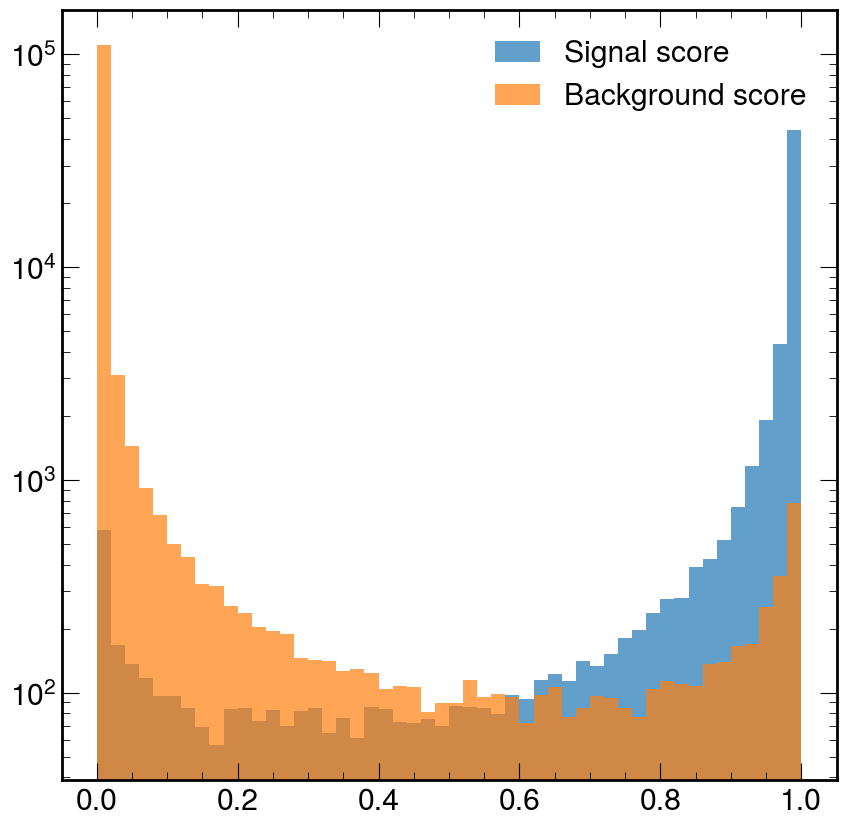

In [22]:
plt.style.use(hep.style.ROOT)
plt.hist(S_score_te, 50, label='Signal score', alpha=0.7)
plt.hist(B_score_te, 50, label='Background score', alpha=0.7)
plt.semilogy()
plt.legend()
plt.savefig(f'{fold}/Scoring.png',bbox_inches='tight')

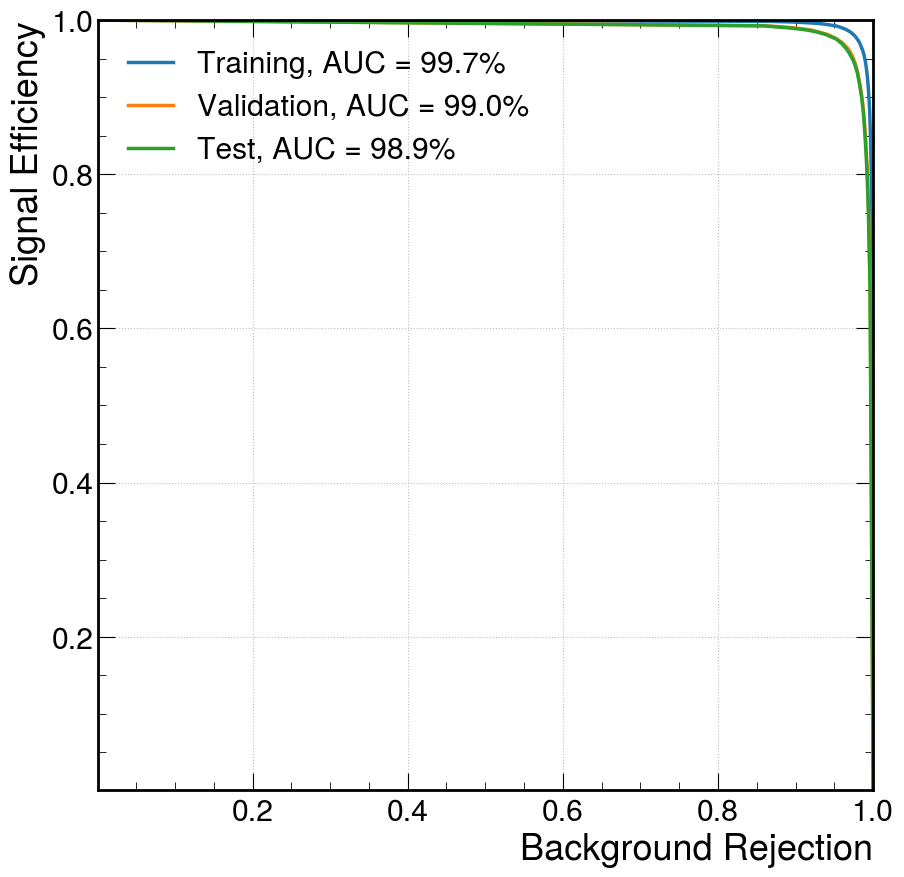

<Figure size 1000x1000 with 0 Axes>

In [9]:
plt.style.use(hep.style.ROOT)
plt.figure()
plt.plot(Brej_tr, Seff_tr, lw=2.5, label="Training, AUC = {:.1f}%".format(auc(Brej_tr,Seff_tr)*100))
plt.plot(Brej_vl, Seff_vl, lw=2.5, label="Validation, AUC = {:.1f}%".format(auc(Brej_vl,Seff_vl)*100))
plt.plot(Brej_te, Seff_te, lw=2.5, label="Test, AUC = {:.1f}%".format(auc(Brej_te,Seff_te)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
#plt.semilogx()
plt.ylim(0.001, 1)
plt.xlim(0.001, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()
plt.savefig(f'{fold}/ROC2.png',bbox_inches='tight')

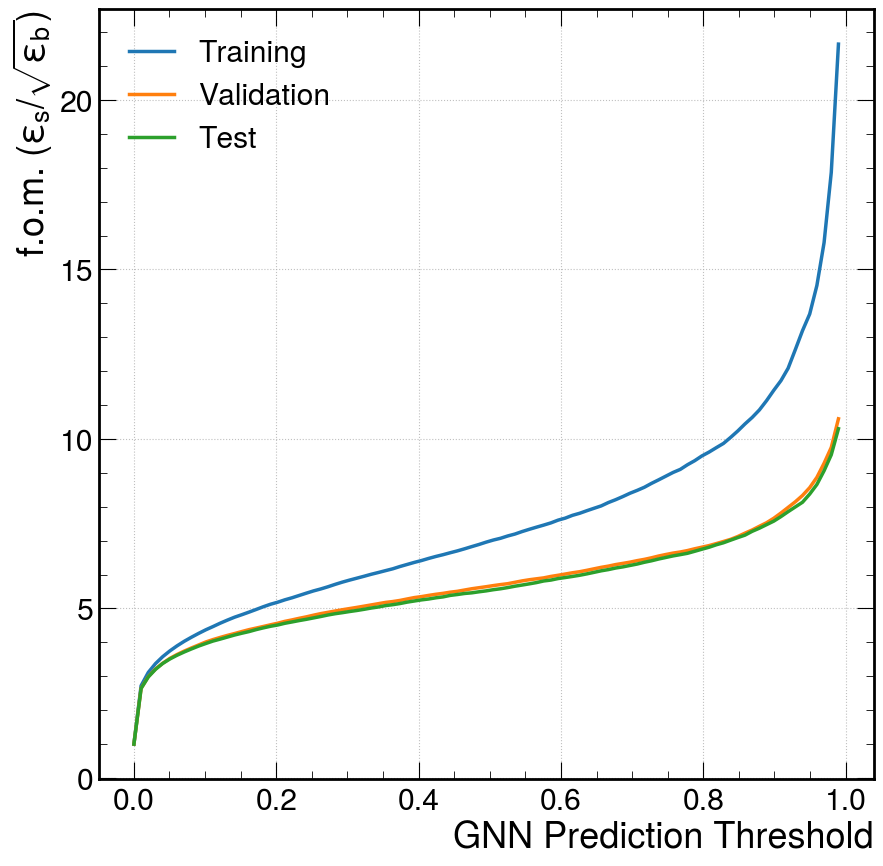

<Figure size 1000x1000 with 0 Axes>

In [10]:
plt.style.use(hep.style.ROOT)
plt.figure()
plt.plot(thre_tr, Figm_tr, lw=2.5, label = "Training")
plt.plot(thre_vl, Figm_vl, lw=2.5, label = "Validation")
plt.plot(thre_te, Figm_te, lw=2.5, label = "Test")
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.legend()
plt.show()
plt.savefig(f'{fold}/FOM.png',bbox_inches='tight')

In [11]:
fom   = [x for x in Figm_te if x!=np.inf]
xmax  = thre_te[np.argmax(fom)]
NBins = 10
EBins = np.linspace(min(E),max(E),NBins+1)
E_sorted, keys_e = zip(*sorted(zip(E,range(0,len(y_test)))))
ERS   = []
ERB   = []

for i in tqdm(range(0,NBins)):
    keys_ei = keys_e[len([x for x in E if x<=EBins[i]]):len([x for x in E if x<=EBins[i+1]])]
    a       = np.array([y_test[x]    for x in keys_ei])
    b       = np.array([y_predict[x] for x in keys_ei])
    PredS   = np.array([a[i] for i in range(0,len(a)) if b[i]>=xmax])
    PredB   = np.array([a[i] for i in range(0,len(a)) if b[i]<xmax])
    try:
        ERS.append(len(PredS[PredS==1])/len(a[a==1]))
    except:
        ERS.append(0)
    try:
        ERB.append(len(PredB[PredB==0])/len(a[a==0]))
    except:
        ERB.append(0)

  0%|          | 0/10 [00:00<?, ?it/s]

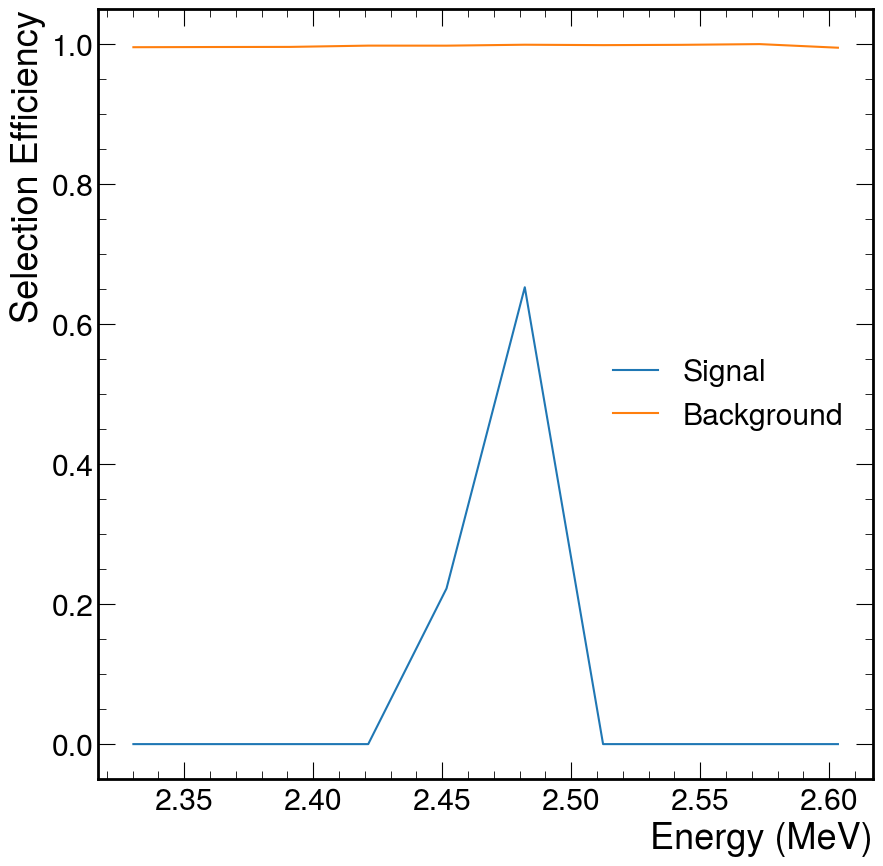

In [12]:
plt.style.use(hep.style.ROOT)

plt.plot(EBins[1:],ERS,label='Signal')
plt.plot(EBins[1:],ERB,label='Background')
plt.ylabel('Selection Efficiency')
plt.xlabel('Energy (MeV)')
plt.legend()
plt.savefig(f'{fold}/Efficiency.png',bbox_inches='tight')

In [13]:
S           = []
B           = []
for i in tqdm(range(0,len(E))):
    if y_predict[i]<xmax:
        B.append(E[i])
    else:
        S.append(E[i])

  0%|          | 0/183543 [00:00<?, ?it/s]

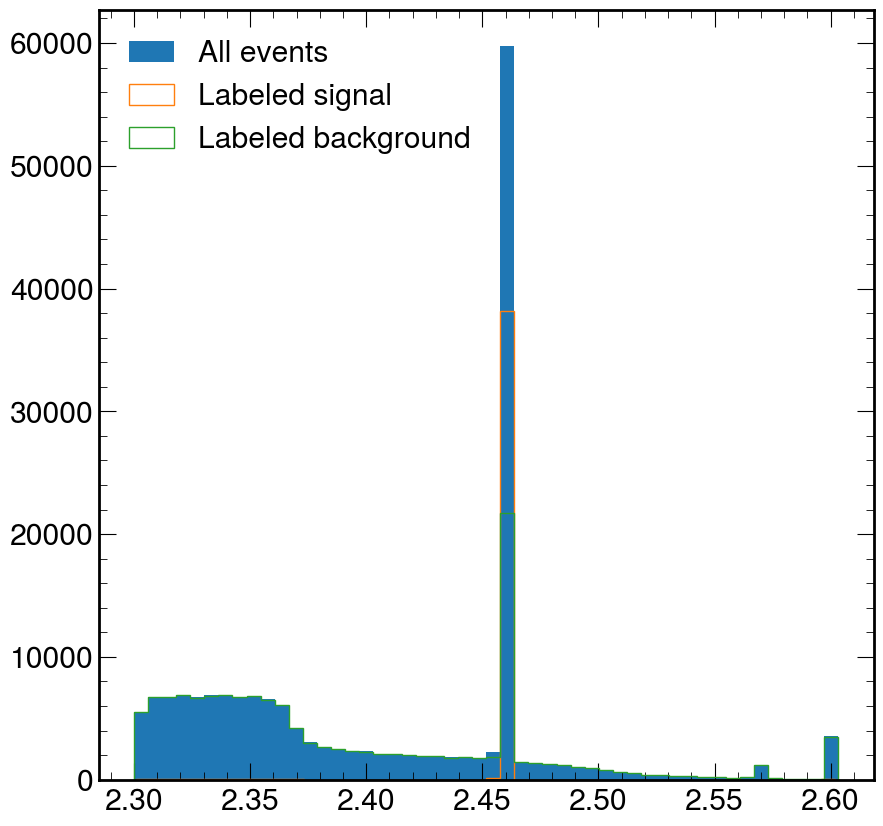

In [14]:
plt.hist(E,50,label='All events')
plt.hist(S,50,histtype='step',label='Labeled signal')
plt.hist(B,50,histtype='step',label='Labeled background');
plt.legend()

In [15]:
Seff_te[np.argmax(fom)]

0.6522811134350185

In [16]:
Brej_te[np.argmax(fom)]

0.9959914698478362

In [17]:
max(fom)

10.30249058964407

In [18]:
thre_PN = thre_te
Figm_PN = Figm_te
Seff_PN = Seff_te
Brej_PN = Brej_te
%store thre_PN
%store Figm_PN
%store Seff_PN
%store Brej_PN

Stored 'thre_PN' (ndarray)
Stored 'Figm_PN' (list)
Stored 'Seff_PN' (list)
Stored 'Brej_PN' (list)


In [19]:
len(E)

183543

In [20]:
tree = uproot.open(fold+'particlenet_predict.root')['Events']
## create a data-frame from all branches included in the TTree
df = tree.arrays(tree.keys(),library='pd')

In [21]:
df

,is_signal,score_is_signal,is_bkg,score_is_bkg,E_tot,ID
0,False,2.645913e-04,True,0.999735,2.337350,81000000.0
1,False,2.138306e-06,True,0.999998,2.323875,81000000.0
2,False,7.635358e-10,True,1.000000,2.389025,81000000.0
3,False,1.910532e-03,True,0.998089,2.326525,81000000.0
4,False,8.645966e-05,True,0.999914,2.378150,81000008.0
...,...,...,...,...,...,...
183538,True,9.895281e-01,False,0.010472,2.458625,230708.0
183539,True,9.986849e-01,False,0.001315,2.458625,230709.0
183540,True,9.714621e-01,False,0.028538,2.459100,230710.0
183541,True,9.904798e-01,False,0.009520,2.459350,230711.0


In [47]:
FalseSignal = df[df.is_signal==False]

In [48]:
FalseSignal = FalseSignal[FalseSignal.score_is_bkg<=0.5]

In [49]:
FalseSignal

,is_signal,score_is_signal,is_bkg,score_is_bkg,E_tot,ID
87,False,0.883136,True,0.116864,2.601025,81000096.0
137,False,0.741072,True,0.258928,2.356300,81000144.0
201,False,0.518878,True,0.481122,2.340675,81000208.0
218,False,0.584954,True,0.415046,2.389900,81000224.0
224,False,0.952726,True,0.047274,2.400250,81000232.0
...,...,...,...,...,...,...
183101,False,0.965262,True,0.034739,2.322150,1400149.0
183139,False,0.719952,True,0.280048,2.312550,1400190.0
183145,False,0.703047,True,0.296953,2.370175,1400196.0
183213,False,0.994716,True,0.005284,2.303425,1400266.0


In [27]:
FalseSignal.ID

377        93356.0
420        93399.0
426        93405.0
452        93431.0
472        93451.0
            ...   
183450    224862.0
183462    224874.0
183480    224892.0
183523    224935.0
183528    224940.0
Name: ID, Length: 2632, dtype: float32

In [30]:
source = pd.DataFrame()
for i in tqdm(range(0,19)):
    tree = uproot.open(f'GNN_datasets/PN_Krishan_3cm_all/prep/next_test_{i}.root')['Events']
    df_i = tree.arrays(tree.keys(),library='pd')
    source = pd.concat([source,df_i], ignore_index=True)

  0%|          | 0/18 [00:00<?, ?it/s]

In [44]:
#store = pd.HDFStore('KrishanPNAll.h5', "w", complib=str("zlib"), complevel=4)
#store.put('dataframe', source, format='table', data_columns=True)
store.close()

In [50]:
FS = source.loc[source['ID'].isin(FalseSignal.ID)]

In [51]:
FalseBackground = df[df.is_signal==True]
FalseBackground = FalseBackground[FalseBackground.score_is_bkg>=0.5]

In [52]:
FB = source.loc[source['ID'].isin(FalseBackground.ID)]

In [60]:
source.keys()

Index(['nPart', 'Part_E', 'Part_Xbin', 'Part_Ybin', 'Part_Zbin', 'is_signal',
       'E_tot', 'ID'],
      dtype='object')

In [78]:
ES = []
for i in tqdm(FS.Part_E):
    ES+=i

  0%|          | 0/3338 [00:00<?, ?it/s]

TypeError: operand type(s) all returned NotImplemented from __array_ufunc__(<ufunc 'add'>, '__call__', <Array [] type='0 * float64'>, <Array [0.000329, 0.00355, ..., 9.55e-05, 8.49e-05] type='421 * float64'>, out=(<Array [] type='0 * float64'>,)): 'Array', 'Array', 'Array'

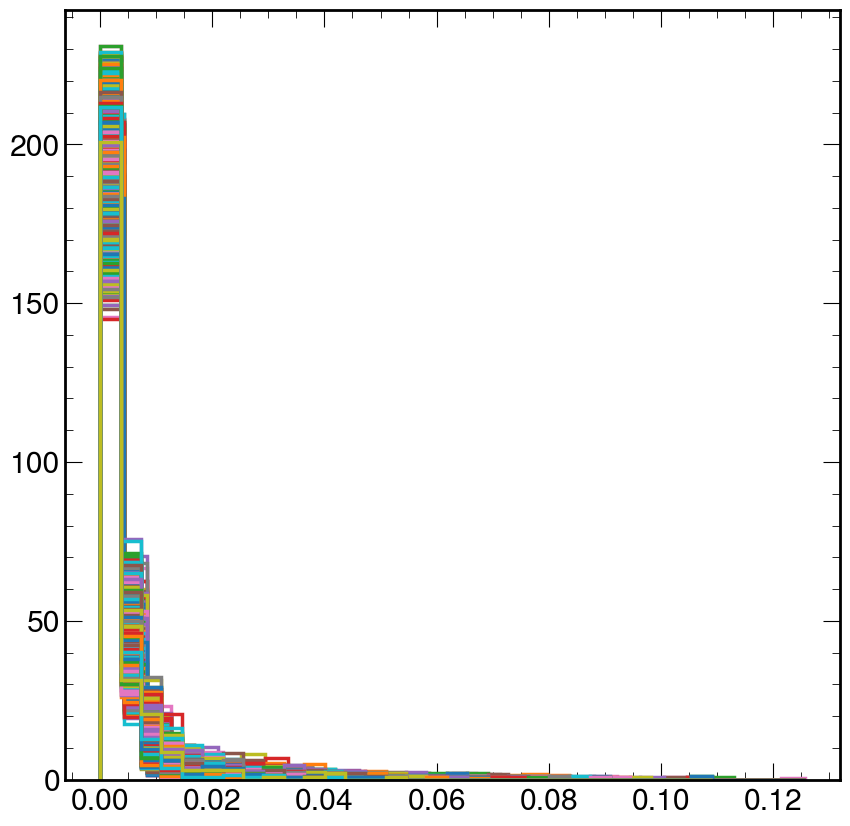

In [63]:
plt.hist(FS.Part_E,30,density=True,histtype='step',lw=2.5);
plt.hist(FB.Part_E,30,density=True,histtype='step',lw=2.5);

In [81]:
ES

<Array [] type='0 * float64'>